Celem tego zadania jest skonstruowanie sieci neuronowej klasyfikującej ręcznie napisane cyfry oraz jej odpowiednie wytrenowanie na danych ze zbioru MNIST, który jest podzielony na 60000 przykładów danych treningowych oraz 10000 przykładów danych testowych. <br>

Para (x_train, y_train) zawiera pary danych treningowych oraz etykiet, natomiast (x_test, y_test) to zbiór odpowiadających sobie danych testowych i etykiet. Elementy par są typu NumPy arrays. <br>

Każda dana reprezentowana jest jako macierz wymiaru 28x28, w której zapisany jest poziom jasności danego piskela.<br>

Dane wejściowe są normalizowane w celu ujednolicenia zakresu cech.<br>

Dodatkowo z dane trójwymiarowe dane przekształcane są na czterowymiarowe uwzględniając liczbę kanałów, czyli różnych składowych kolorów, w naszym przypadku 1, gdyż zdjęcia są w skali szarości. Dla przykładu zdjęcia kolorowe miały by 3 kanały odpowiadające barwom czerwonej, zielonej oraz niebieskiej.<br>

Etykiety klas z pojedynczych wartości liczbowych zamieniane są na wektory, w których tylko jedna zmienna ustawiona jest na 1 (identyfikująca klasę etykiety), a reszta składowych ustawiona jest na 0. Dzięki temu zachwoujemy kompatybilność z funkcją straty "categorical_crossentropy".

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

2025-04-04 10:21:22.113087: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 10:21:22.263092: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 10:21:22.363399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743754882.470773    5037 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743754882.499468    5037 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743754882.677493    5037 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Do rozwiązania tego problemu została wykorzystana **konwolucyjna sieć neuronowa**, która działa w oparciu o splot dykretny, stworzona na wzór biologicznego mechanizmu analizowania obrazów. Można ją podzielić na:
- **warstwy konwolucyjne** - w tych warstwach dochodzi do przesuwania niedużych filtrów, które dla aktualnie obserwowanego obszaru wyliczają splot dyskretny z kernelem (filtrem). W procesie trenowania każdy z filtrów uczony jest do wychwytywania określonych cech. Wyniki warstwy konwolucyjnej przepuszczane są przez funkcję aktywacji, u nas **relu**
- **warstwy poolingowe** - zmniejszanie wymiaru macierzy uzyskany poprzez operacje na warstwie konwolucyjnej poprzez wybranie maksymalnej wartości z obszaru 2x2 (max pooling)
- **warstwa w pełni połączona** - klasyczny perceptron wielowarstwowy stanowiący połaczenie wszystkich cech
- **warstwa wyjściowa** - warstwa decyzyjna reprezentująca każdą z klas <br>

Zaprojektowana sieć konwolucyjna składa się z 3 warstw konwolucyjnych o 64 filtrach rozmiaru 2x2 oraz funkcji aktywacji relu przeplatanych z warstwami poolingowymi z filtrami rozmiaru 2x2. Dodatkowo używamy mechanizmu **dropout**, który losowo opuszcza zdefiniowany procent neuronów w procesie treningowym (u nas 25%) w celu uniknięcia przeuczenia. Pomiędzy warstwami konwolucyjnymi a w pełni połączonymi dochodzi do wypłaszczenia macierzy oraz zareprezentowania ich w postaci wektora w celu dostarczenia danych wejściowych do w pełni połączonej warstwy. U nas składa się o nas z 64 neuronów z funkcją aktywacji relu oraz procentem dropoutu ustawionym na 25%. Ostatnia warstwa, wyjściowa, to 10 neuronów po jednym dla każdej z klas. Funkcją aktywacji jest tutaj funkcja **softmax** dzięki czemu suma wartości wszystkich neuronów w tej warstwie wynosi 1, co pozwala na traktowanie wyjścia jako prawdopodobieństwa przypisania obrazu do jednej z 10 klas. Model wybiera klasę z najwyższym prawdopodobieństwem.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

model = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(64, (2,2), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(64, (2,2), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(64, (2,2), activation='relu'),
    Dropout(0.25),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(10, activation='softmax')
])

2025-04-04 10:21:31.431781: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Do wytrenowania modelu został użyty optymalizator **Adam**, czyli algorytm dostosowujący wagi w trackie uczenia. Użytą funkcją straty jest **categorical cross entropy**, która mierzy, jak bardzo przewidywane prawdopodobieństwa różnią się od rzeczywistych etykiet. <br>

W procesie uczenia model 50 razy przechodzi przez te same dane, przetwarzając na raz 128 próbek danych oraz porównując z danymi testowymi w celu uniknięcia przeuczenia na danych treningowych.

In [3]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.7463 - loss: 0.7559 - val_accuracy: 0.9750 - val_loss: 0.0811
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9591 - loss: 0.1334 - val_accuracy: 0.9841 - val_loss: 0.0496
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9709 - loss: 0.0970 - val_accuracy: 0.9875 - val_loss: 0.0385
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9767 - loss: 0.0742 - val_accuracy: 0.9892 - val_loss: 0.0342
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.9793 - loss: 0.0663 - val_accuracy: 0.9890 - val_loss: 0.0333
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9820 - loss: 0.0590 - val_accuracy: 0.9908 - val_loss: 0.0282
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9851 - loss: 0.0481 - val_accuracy: 0.9908 - val_loss: 0.0276
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9853 - loss: 0.0467 - 

AttributeError: module 'tensorflow.keras' has no attribute 'model'

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

[[ 978    0    0    0    0    0    1    0    0    1]
 [   0 1133    1    0    0    0    0    1    0    0]
 [   1    1 1028    0    0    0    0    1    1    0]
 [   0    0    1 1003    0    4    0    1

W celu weryfikacji modelu dostarczone zostały dane testowe spoza zbioru MNIST (stworzone własnoręcznie). W celu wykorzystania ich do ewaluacji modelu należy je najpierw oetykietować.

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

image_files = [f for f in os.listdir("data/") if f.endswith('.jpg')]

labels = {}
for img_name in image_files:
    label = input(f"Enter label for {img_name}: ")
    labels[img_name] = label

with open('labels.txt', 'w') as f:
    for img_name, label in labels.items():
        f.write(f"{img_name} {label}\n")

Enter label for eightc.jpg:  8
Enter label for zerob.jpg:  0
Enter label for oned.jpg:  1
Enter label for ninec.jpg:  9
Enter label for zerod.jpg:  0
Enter label for sevena.jpg:  7
Enter label for zeroa.jpg:  0
Enter label for twoe.jpg:  2
Enter label for twod.jpg:  2
Enter label for sixd.jpg:  6
Enter label for zeroc.jpg:  0
Enter label for sixe.jpg:  6
Enter label for threea.jpg:  3
Enter label for threed.jpg:  3
Enter label for threee.jpg:  3
Enter label for twob.jpg:  2
Enter label for eightd.jpg:  8
Enter label for threec.jpg:  3
Enter label for sevenb.jpg:  7
Enter label for eighte.jpg:  8
Enter label for nineb.jpg:  9
Enter label for twoc.jpg:  2
Enter label for zeroe.jpg:  0
Enter label for sevene.jpg:  7
Enter label for fivee.jpg:  5
Enter label for foure.jpg:  4
Enter label for oneb.jpg:  1
Enter label for eighta.jpg:  8
Enter label for twoa.jpg:  2
Enter label for threeb.jpg:  3
Enter label for onec.jpg:  1
Enter label for ninea.jpg:  9
Enter label for fourd.jpg:  4
Enter la

In [17]:
label_map = {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6": 6,
    "7": 7,
    "8": 8,
    "9": 9
}

y_true = np.array([labels[image_file] for image_file in image_files])
y_true_numeric = [label_map[label] for label in y_true]

In [18]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    img = img / 255.0
    img = img.reshape(28, 28, 1)
    return img

X_test = np.array([preprocess_image(os.path.join("data/", f)) for f in image_files])

y_pred = np.argmax(model.predict(X_test), axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/home/ewa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ewa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ewa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.28      1.00      0.43         5
           2       0.80      0.80      0.80         5
           3       0.80      0.80      0.80         5
           4       0.00      0.00      0.00         5
           5       0.25      0.40      0.31         5
           6       0.00      0.00      0.00         5
           7       1.00      0.20      0.33         5
           8       0.00      0.00      0.00         5
           9       0.50      0.60      0.55         5

    accuracy                           0.48        50
   macro avg       0.43      0.48      0.41        50
weighted avg       0.43      0.48      0.41        50

[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [1 0 0 4 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 3]
 [1 0 0 0 0 4 0 0 0 0]
 [0 3 1 0 0 0 0 1 0 0]
 [0 2 0 1 0 2 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 3]]


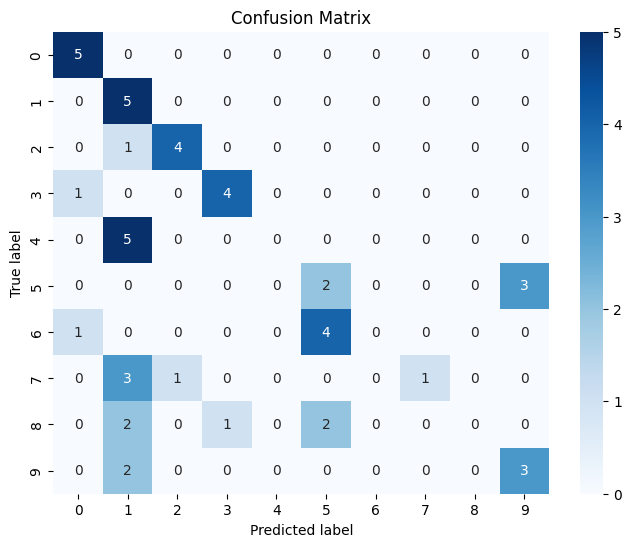

In [23]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(y_true_numeric, y_pred))
conf_matrix = confusion_matrix(y_true_numeric, y_pred)
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
